In [1]:
from scipy.io import loadmat
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")

In [3]:
results=loadmat('pvprog_input.mat')
time1=results['time']
P_ld1=results['P_ld']
p_pv1=results['p_pv']
time=[]
P_ld=[]
p_pv=[]
i=0
while i<len(p_pv1):
    p_pv.append(p_pv1[i][0])
    P_ld.append(P_ld1[i][0])
    time.append(time1[i][0])
    i+=1
p_pv=np.array(p_pv)
P_ld=np.array(P_ld)
time=np.array(time)
P_stc=5 # Nennleistung des PV-Generators in kWp
C_bu=5 # nutzbare Speicherkapazität des Batteriespeichers in kWh 
P_bwr=2.5# % Nennleistung des Batteriewechselrichters in kW
p_gfl=0.5#  spezifische Einspeisegrenze in kW/kWp (z.B. 50%-Einspeisebegrenzung des KfW-Programms)
dt=60# % Zeitschrittweite in s
eta_batt=0.95# % Wirkungsgrad des Lithium-Batteriespeichers (ohne AC/DC-Wandlung)
eta_bwr=0.94# % Wirkungsgrad des Batteriewechselrichters
tf_past=3# % Rückblick-Zeitfenster der PV-Prognose in h 
tf_prog=15# % Prognosehorizont der PV- und Lastprognose in h
del (P_ld1, time1 , p_pv1 , results)

In [24]:
results=loadmat('pvprog_input.mat')
time1=results['time']
P_ld1=results['P_ld']
p_pv1=results['p_pv']
time=[]
P_ld=[]
p_pv=[]
for t in range(0,len(p_pv1),15):
    p_pv.append(p_pv1[t:t+14].mean())
    P_ld.append(P_ld1[t:t+14].mean())
    time.append(time1[t][0])
p_pv=np.array(p_pv)
P_ld=np.array(P_ld)
time=np.array(time)
P_stc=5 # Nennleistung des PV-Generators in kWp
C_bu=5 # nutzbare Speicherkapazität des Batteriespeichers in kWh 
P_bwr=2.5# % Nennleistung des Batteriewechselrichters in kW
p_gfl=0.3#  spezifische Einspeisegrenze in kW/kWp (z.B. 50%-Einspeisebegrenzung des KfW-Programms)
dt=60*15# % Zeitschrittweite in s
eta_batt=0.95# % Wirkungsgrad des Lithium-Batteriespeichers (ohne AC/DC-Wandlung)
eta_bwr=0.94# % Wirkungsgrad des Batteriewechselrichters
tf_past=3# % Rückblick-Zeitfenster der PV-Prognose in h 
tf_prog=15# % Prognosehorizont der PV- und Lastprognose in h
del (P_ld1, time1 , p_pv1 , results)

In [25]:
def batt_sim(dt,P_b,C_bu,P_bwr,eta_batt,eta_bwr,soc_0):
    """Inhalt: Einfaches Batteriespeichermodell, in dem Wandlungsverluste durch
    % konstante Verlustfaktoren berücksichtigt sind. 

    % Quelle: J. Weniger: Dimensionierung und Netzintegration von
    % PV-Speichersystemen. Masterarbeit, Hochschule für Technik und Wirtschaft
    % HTW Berlin, 2013"""
    # Mögliche AC-seitige Batterieleistung auf die
    # Batteriewechselrichter-Nennleistung begrenzen
    P_b=np.maximum(-P_bwr*1000,np.minimum(P_bwr*1000,P_b))
    #Batteriespeicherinhalt im Zeitschritt zuvor
    E_b0=soc_0*C_bu*1000
    if P_b>=0:# %Batterieladung
        # Mögliche DC-seitige Batterieleistung unter Berücksichtigung des
        # Batteriewechselrichter-Wirkungsgrads bestimmen
        P_b=P_b*eta_bwr
        #Ladung
        E_b=np.minimum(C_bu*1000, E_b0+eta_batt*P_b*dt/3600)
        # Anpassung der wirklich genutzten Leistung
        P_b=np.minimum(P_b,(C_bu*1000-E_b0)/(eta_batt*dt/3600))
    
    else:# % Batterieentladung´
        #Mögliche DC-seitige Batterieleistung unter Berücksichtigung des
        # Batteriewechselrichter-Wirkungsgrads bestimmen
        P_b=P_b/eta_bwr
        #Entladung
        E_b=np.maximum(0, E_b0+P_b*dt/3600)
        #Anpassung der wirklich genutzten Leistung
        P_b=np.maximum(P_b,(-E_b0)/(dt/3600))

    #Realisierte AC-seitige Batterieleistung
    if P_b >0:#Ladung
        P_b=P_b/eta_bwr
    else:#Entladung
        P_b=P_b*eta_bwr
    #Ladezustand
    soc=E_b/(C_bu*1000)
    return(P_b,soc)


In [26]:
def simu_erg(P_pv,P_ld,P_b,P_stc,p_gfl):
    P_d=P_pv-P_ld
    P_du=np.minimum(P_pv,P_ld)
    P_bc=np.maximum(0,P_b)
    P_bd=abs(np.minimum(0,P_b))
    P_gf=np.maximum(0,np.minimum(P_stc*1000*p_gfl,P_d-P_bc))
    P_gs=abs(np.minimum(0,P_d+P_bd))
    P_ct=P_pv-P_du-P_bc-P_gf

    E_pv=P_pv.mean()*8.76
    E_ld=P_ld.mean()*8.76
    E_du=P_du.mean()*8.76
    E_bc=P_bc.mean()*8.76
    E_bd=P_bd.mean()*8.76
    E_gf=P_gf.mean()*8.76
    E_gs=P_gs.mean()*8.76
    E_ct=P_ct.mean()*8.76

    a = (E_du+E_bd)/E_ld
    v = E_ct/E_pv
    return (a,v,E_pv,E_ld,E_du,E_bc,E_bd,E_gf,E_gs,E_ct)


In [27]:
def prog4pv(dt,time,p_pv,tf_past,tf_prog):
    """% Inhalt: Erstellung der PV-Prognosen auf Basis der historischen Messwerte
    #% der PV-Leistung in Abhängigkeit vom Prognosehorizont und
    #% Rückblickzeitfenster.

    #% Quelle: J. Bergner, J. Weniger, T. Tjaden, V. Quaschning: Verbesserte
    % Netzintegration von PV-Speichersystemen durch Einbindung lokal
    % erstellter PV- und Lastprognosen. 30. Symposium Photovoltaische
    % Solarenergie. Bad Staffelstein, 2015
    """
    # Vorinitialisierung
    p_pvmax=np.zeros(len(time))
    KTF=np.zeros(len(time))
    p_pvf=np.zeros((np.int64(len(time)*dt/900),math.ceil(tf_prog*4)))
    # Tagesverlauf der maximalen PV-Leistungsabgabe aus den Messwerten der
    # vergangenen 10 Tage bestimmen
    for t in range(int(86400/dt)-1, len(time)-int(86400/dt), int(86400/dt)):
        #Anzahl der Tage, die zurückgeguckt wird (max. 10 Tage)
        d_pv=int(np.minimum(math.ceil(t*dt/86400),10))
        #% spezifische PV-Leistung während des Zeitraums  
        p_pvsel=p_pv[t-d_pv*int(86400/dt)+1:t+1]
        #maximalen Tagesverlauf der PV-Leistung bestimme
        p_pvmax[t:t+int(86400/dt)]=(np.max(np.reshape(p_pvsel,(int(86400/dt),d_pv),order='F'),1))

    #Nachtindikator (Zeitraum ohne PV-Erzeugung) bestimmen
    n=p_pv<=0
    #PV-Leistung und max. PV-Leistung für Zeitraum mit PV-Erzeugung
    p_pv_day=p_pv[~n]
    pv_max_day=p_pvmax[~n]
    E_pv_past=np.zeros(sum(~n))
    E_max=np.zeros(sum(~n))
    #Aktuelle und maximale PV-Energie im Rückblick-Zeitfenster bestimmen
    for t in range(tf_past*int(3600/dt),len(p_pv_day)):
        E_pv_past[t]=sum(p_pv_day[t-tf_past*int(3600/dt):t])
        E_max[t]=sum(pv_max_day[t-tf_past*int(3600/dt):t])
    # Verhältnis von aktueller zu maximaler PV-Energie (Wetterlage-Index KTF) im Rückblickzeitfenster berechnen
    k_TF=np.divide(E_pv_past,E_max)
    KTF[~n]=k_TF
    #15-Minutenmittelwerte von KTF und der maximalen PV-Leistungsabgabe p_pvmax
    KTF15=np.mean(np.reshape(KTF,(int(3600/dt/4),int(len(time)/(3600/dt/4))),order='F'),axis=0)
    p_pvmax15=np.mean(np.reshape(p_pvmax,(int(3600/dt/4),int(len(time)/(3600/dt/4))),order='F'),axis=0)
    #Zeitreihe p_pvmax15 zweimal verketten, um zum Ende der Jahressimulation auf die Maximalwerte des Jahresanfangs zurückzugreifen
    p_pvmax15=(np.append(p_pvmax15,p_pvmax15))
    #Messwertbasierte PV-Prognose erstellen: Multiplikation des aktuellen KTF15-Wertes mit dem Verlauf der maximalen PV-Leistung des Prognosehorizonts
    for t in range(0,len(p_pvf)):
        p_pvf[t,:]=np.maximum(0,np.minimum(1,KTF15[t]*(p_pvmax15[t:t+tf_prog*4])))
    # PV-Prognosen ohne Zahlenwert null setzen
    p_pvf[np.where(np.isnan(p_pvf))]=0
    return(p_pvf)
    


In [28]:
def prog4ld(dt,time,P_ld,tf_prog):
    """
% Inhalt: Erstellung der Lastprognosen auf Basis der historischen Messwerte
% der Last. Dabei werden der Mittelwert der vergangenen 15 min (aktuelle
% Persistenz) sowie das Lastprofil des vorangegangenen Tages
% (Tagespersistenz) über den Prognosehorizont unterschiedlich stark
% gewichtet. 

% Quelle: J. Bergner, J. Weniger, T. Tjaden, V. Quaschning: Verbesserte
% Netzintegration von PV-Speichersystemen durch Einbindung lokal
% erstellter PV- und Lastprognosen. 30. Symposium Photovoltaische
% Solarenergie. Bad Staffelstein, 2015"""
    #% Vorinitialisierung
    P_ldf=np.zeros((int(len(time)*dt/900),(tf_prog*4)))

    # 15 min-Zeitstempel für die Prognosen
    time_f=time[range(0,len(time)-int(900/dt)+1,int(900/dt))]
    # Lastprofil in 15-minütiger Auflösung ermitteln
    P_ld15=np.mean(np.reshape(P_ld,(int(900/dt),int(len(time)/int(900/dt))),order='F'),axis=0)
    #Gewichtungsfaktoren für die aktuelle Persistenz und Tagespersistenz über den Prognosehorizont variieren
    g1=1/math.exp(-0.1)*np.exp(-0.1*(np.arange(tf_prog*4)+1))#aktuelle Persistenz
    g2=1-g1#Tagespersistenz
    #Messwertbasierte Lastprognose erstellen: Variable Gewichtung von aktueller Persistenz und Tagespersistenz über den Prognosehorizont
    for t in range(96,len(time_f)):
        P_ldf[t,:]=g1*np.full(int(tf_prog*4),P_ld15[t-1])+g2*P_ld15[t-96:t-96+int(tf_prog*4)]
    
    return (P_ldf,time_f)

In [29]:
def batt_prog(t,dt,P_df,soc,P_stc,C_bu,p_gfl,eta_batt,eta_bwr):
  """ 
% Inhalt: Erstellung eines Fahrplans für die Batterieleistung über den
% Prognosehorizont der PV- und Lastprognose. Hierzu wird die virtuelle
% Einspeisegrenze für den Betrachtungszeitraum soweit minimiert, dass die
% überschüssige PV-Energie oberhalb dieser Grenze den Batteriespeicher
% möglichst vollständig lädt. 

% Quelle: J. Weniger, V. Quaschning: Begrenzung der Einspeiseleistung von
% netzgekoppelten Photovoltaiksystemen mit Batteriespeichern. In: 28.
% Symposium Photovoltaische Solarenergie. Bad Staffelstein, 2013

% Weitergehende Informationen zur prognosebasierten Batterieladeplanung: 
% J. Bergner: Untersuchungen zu prognosebasierten Betriebsstrategien für
% PV-Speichersysteme. Berlin, Hochschule für Technik und Wirtschaft
% Berlin, Bachelorthesis, 2014 """

  #aktueller Prognosezeitschritt
  t_fsel=math.floor(t*dt/900)
  # aktuelle Differenzleistungsprognose auswählen
  P_dfsel=P_df[t_fsel,:]
  # Batterieladezustand und Batterieinhalt im Zeitschritt zuvor
  soc_0=soc[t-1]
  E_b0=soc_0*C_bu*1000
  # Vorbereitung der Bestimmung der aktuellen virtuellen Einspeisegrenze durch Variation der virtuellen Einspeisegrenze in 0,01 kW/kWp-Schritten
  p_gflvir=np.reshape(np.repeat(np.arange(0,p_gfl+0.01,0.01),len(P_dfsel),0),[int(tf_prog*4),int(p_gfl*100+1)],order='F')
  # Prognostizierte überschüssige PV-Leistung
  P_sf=np.reshape(np.repeat(np.maximum(0,P_dfsel),p_gflvir.shape[1],0),p_gflvir.shape)
  # Idendifikation der minimalen virtuellen Einspeisegrenze, die über den Prognosehorizont eingehalten werden soll: Dabei soll die Energiemenge 
  #oberhalb dieser Grenze ausreichend sein, um den Batteriespeicher über den Prognosehorizont möglichst vollständig zu laden.
  value=(abs(np.sum(np.maximum(0,(P_sf-p_gflvir*P_stc*1000))*eta_batt*eta_bwr*dt*900/dt/3600,axis=0)-(C_bu*1000-E_b0)))
  idx=np.where(value==np.min(value))[0][0]
  p_gflvir=p_gflvir[0,idx]
  # Batterieladeleistung über Prognosehorizont aus virtueller Einspeisegrenze ableiten
  P_bcf=np.maximum(0,P_dfsel-p_gflvir*P_stc*1000)
  # Batterieleistung aus Batterieladeleistung und Differenzleistung über Prognosehorizont bestimmen
  P_bf=np.round(np.minimum(P_bcf,P_dfsel))
  return (P_bf,P_dfsel)
  

In [30]:
def err_ctrl(t,P_d,P_dfsel,P_bf,P_stc,P_bwr,p_gfl):
    """% Inhalt: Anpassung der geplanten Batterieleistung zum Ausgleich von
    % Prognosefehlern. Hierzu wird die prognostizierte Ladeleistung durch eine
    % Regelung um die Differenz zwischen den Prognose- und Messwerten
    % korrigiert.

    % Quelle: J. Weniger, J. Bergner, V. Quaschning: Integration of PV power
    % and load forecasts into the operation of residential PV battery systems.
    % In: 4th Solar Integration Workshop. Berlin, 2014"""

    if P_d[t]>0:#(Leistungsüberschuss)
        """ % Anpassung der Ladeleistung, wenn die aktuelle Differenzleistung größer
            % null und überschüssige PV-Leistung vorhanden ist
            %
            % Batterieladeleistung wird angepasst, wenn eine der folgenden
            % Bedingungen erfüllt wird:
            %
            % (1) Die für den aktuellen Zeitschritt prognostizierte
            % Batterieleistung ist ungleich null
            % (2) Die aktuelle Differenzleistung ist größer als die max.
            % prognostizierte Einspeiseleistung (virtuelle Einspeisegrenze)
            % während des Prognosehorizonts
            % (3) Die aktuelle Differenzleistung übersteigt die max. zulässige
            % Einspeisegrenze"""
        
        if (P_bf[0]!=0) or (P_d[t]>np.max(P_dfsel-P_bf)) or (P_d[t]>p_gfl*P_stc*1000):
            """ % Aktuelle Ladeleistung um die Differenz zwischen der aktuellen
                % Differenzleistung P_d(t) und der prognostizierten Differenzleistung
                % P_dfsel(1) korrigieren. Dadurch wird gewährleistet, dass die
                % zuvor ermittelte virtuelle Einspeisegrenze eingehalten wird"""
                
            # Ladeleistung auf die Nennleistung des Batteriewechselrichters begrenzen
            P_b=np.maximum(0,P_bf[0]+P_d[t]-P_dfsel[0])
            # Ladeleistung auf die Nennleistung des Batteriewechselrichters begrenzen
            P_b=np.minimum(P_bwr*1000,P_b)
        else:
            """ % Wenn keine der zuvor aufgeführten Bedingungen erfüllt wird, soll
                % die aktuelle Batterieladeleistung auf null gesetzt werden.
                % Dadurch wird eine stufige Anpassung der Einspeiseleistung
                % verhindert."""
            P_b=0
    else:#% P_d(t)<0 (Leistungsdefizit)
        """ % Entladeleistung gemäß Leistungsdefizit anpassen und auf die Nennleistung des
            % Batteriewechselrichters begrenzen."""
        P_b=np.maximum(-P_bwr*1000,P_d[t])  
    return(P_b)

In [36]:
bslist=[2]
for bs in bslist:
    P_b=np.zeros(len(time))
    soc=np.zeros(len(time))
    if bs==1:
        P_pv=p_pv*P_stc*1000
        if C_bu>0:
            P_b=P_pv-P_ld 
            for t in range(1,len(time)):
                P_b[t],soc[t]=batt_sim(dt,P_b[t],C_bu,P_bwr,eta_batt,eta_bwr,soc[t-1])
    #a,v,E_pv,E_ld,E_du,E_bc,E_bd,E_gf,E_gs,E_ct=simu_erg(P_pv,P_ld,P_b,P_stc,p_gfl)
    if bs==2:
        p_pvf=prog4pv(dt,time,p_pv,tf_past,tf_prog)
        P_ldf,time_f = prog4ld(dt,time,P_ld,tf_prog)
        P_pv=p_pv*P_stc*1000
        P_pvf=p_pvf*P_stc*1000
        P_d=P_pv-P_ld
        P_df=P_pvf-P_ldf
        P_bf = 0
        P_dfsel = 0
        if C_bu>0:
            for t in range(1,len(time)):
                t_fsel=math.floor(t*dt/900)
                if (sum(P_pv[t:np.minimum(t+int(900/dt)+1,len(P_pv))])>0)&(time[t]==time_f[t_fsel]):
                    P_bf,P_dfsel=batt_prog(t,dt,P_df,soc,P_stc,C_bu,p_gfl,eta_batt,eta_bwr)
                P_b[t]=err_ctrl(t,P_d,P_dfsel,P_bf,P_stc,P_bwr,p_gfl)
                P_b[t],soc[t]=batt_sim(dt,P_b[t],C_bu,P_bwr,eta_batt,eta_bwr,soc[t-1]) 
        a,v,E_pv,E_ld,E_du,E_bc,E_bd,E_gf,E_gs,E_ct=simu_erg(P_pv,P_ld,P_b,P_stc,p_gfl)

In [37]:
print('PV-Energie E_pv:         ',E_pv)
print('Verbrauch E_ld:          ',E_ld)
print('PV direct usage E_du:    ',E_du)
print('Batterieladung E_bc:     ',E_bc)
print('Batterieentladung E_bd:  ',E_bd)
print('Netzeinspeisung E_gf:    ',E_gf)
print('Netzbezug E_gs:          ',E_gs)
print('Abregelung E_ct:         ',E_ct)
print('Autarkiegrad a:          ',a)
print('Abregelungsverluste v:   ',v)

PV-Energie E_pv:          5020.245999980877
Verbrauch E_ld:           5009.749000000001
PV direct usage E_du:     1570.971483605976
Batterieladung E_bc:      1313.5580696645147
Batterieentladung E_bd:   1102.6269148377867
Netzeinspeisung E_gf:     1716.4725998568783
Netzbezug E_gs:           2336.1506015562372
Abregelung E_ct:          419.24384685350884
Autarkiegrad a:           0.5336791121558709
Abregelungsverluste v:    0.0835106181759033


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
P_d=P_pv-P_ld
P_du=np.minimum(P_pv,P_ld)
P_bc=np.maximum(0,P_b)
P_bd=abs(np.minimum(0,P_b))
P_gf=np.maximum(0,np.minimum(P_stc*1000*p_gfl,P_d-P_bc))
P_gs=abs(np.minimum(0,P_d+P_bd))
P_ct=P_pv-P_du-P_bc-P_gf

pfm= pd.DataFrame()
var=[P_pv,P_ld,P_du,P_bc,P_bd,P_gf,P_gs,P_ct]
vars=['P_pv','P_ld','P_du','P_bc','P_bd','P_gf','P_gs','P_ct']
for i in range(0,8):
    pfm[vars[i]]=np.mean(np.reshape(var[i],(96,365),order='F'),1)
pfm['time']=range(1,97)
pfm['P_cta']=pfm['P_ct']+pfm['P_du']+pfm['P_bc']+pfm['P_gf']
pfm['P_dua']=pfm['P_du']+pfm['P_bc']+pfm['P_gf']
pfm['P_bca']=pfm['P_bc']+pfm['P_gf']


pfm['P_gs']=-pfm['P_gs']-pfm['P_bd']-pfm['P_du']
pfm['P_bd']=-pfm['P_bd']-pfm['P_du']
pfm['P_du']=-pfm['P_du']



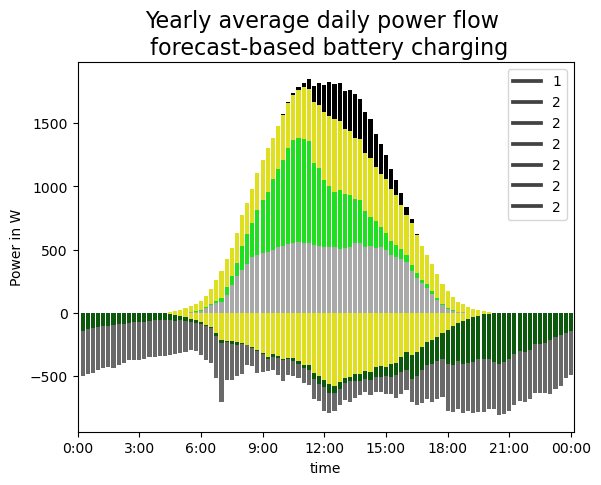

In [40]:
sns.reset_defaults()
s1 = sns.barplot(x='time',y = 'P_cta',data = pfm, color = 'black')
s2 = sns.barplot(x='time',y = 'P_dua', data = pfm, color = 'yellow')
s3 = sns.barplot(x='time',y = 'P_bca', data = pfm, color = 'lime')
s4 = sns.barplot(x='time',y = 'P_gf', data = pfm, color = 'darkgrey')
s5 = sns.barplot(x='time',y = 'P_gs', data = pfm, color = 'dimgrey')
s6 = sns.barplot(x='time',y = 'P_bd', data = pfm, color = 'darkgreen')
s7 = sns.barplot(x='time',y = 'P_du', data = pfm, color = 'yellow')

plt.title('Yearly average daily power flow \n forecast-based battery charging', fontsize=16)

#add axis titles
plt.xticks(range(-1,96,12),['0:00','3:00','6:00','9:00','12:00','15:00','18:00','21:00','00:00'])
plt.ylabel('Power in W')
plt.legend(labels=["1","2","2","2","2","2","2"])
plt.show()

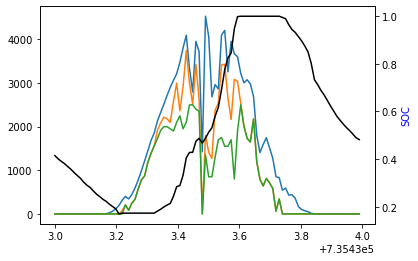

In [14]:
# plot
fig, ax1 = plt.subplots()
h=198
#ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)
ax1.plot(time[h*96:(h+1)*96], P_du[h*96:(h+1)*96]+P_bc[h*96:(h+1)*96]+P_gf[h*96:(h+1)*96])
ax1.plot(time[h*96:(h+1)*96], P_bc[h*96:(h+1)*96]+P_gf[h*96:(h+1)*96])
ax1.plot(time[h*96:(h+1)*96], P_gf[h*96:(h+1)*96])

ax2 = ax1.twinx() 
ax2.set_ylabel('SOC', color = 'blue') 
ax2.plot(time[h*96:(h+1)*96], soc[h*96:(h+1)*96], color = 'black') 
plt.show()

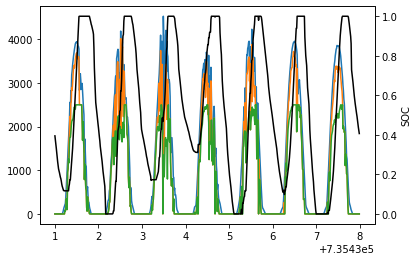

In [18]:
# plot
fig, ax1 = plt.subplots()
h=196
#ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)
ax1.plot(time[h*96:(h+7)*96], P_du[h*96:(h+7)*96]+P_bc[h*96:(h+7)*96]+P_gf[h*96:(h+7)*96])
ax1.plot(time[h*96:(h+7)*96], P_bc[h*96:(h+7)*96]+P_gf[h*96:(h+7)*96])
ax1.plot(time[h*96:(h+7)*96], P_gf[h*96:(h+7)*96])

ax2 = ax1.twinx() 
ax2.set_ylabel('SOC', color = 'black') 
ax2.plot(time[h*96:(h+7)*96], soc[h*96:(h+7)*96], color = 'black') 
plt.show()